In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
from nltk.tokenize import word_tokenize
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedakram1","key":"66701960f6726013c71587d887b8253a"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
  0% 0.00/25.7M [00:00<?, ?B/s]
100% 25.7M/25.7M [00:00<00:00, 924MB/s]


In [7]:
!unzip /content/imdb-dataset-of-50k-movie-reviews.zip

Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [8]:
df = pd.read_csv("/content/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
X,y = df["review"].values, df["sentiment"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((37500,), (12500,), (37500,), (12500,))

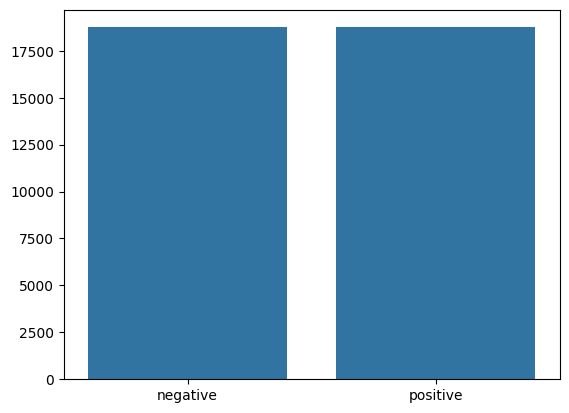

In [10]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [11]:
stop_words = set(stopwords.words('english'))

def preprocess_string(s):
    # Remove non-alphanumeric characters and digits, lowercase
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\d", '', s)
    return s.lower().strip()

def tokenize(x_train, y_train, x_val, y_val, vocab_size=1000, max_len=50):
    word_list = []

    # Build vocabulary from training data
    for sent in x_train:
        tokens = word_tokenize(sent)
        for word in tokens:
            word = preprocess_string(word)
            if word and word not in stop_words:
                word_list.append(word)

    # Most common words
    corpus = Counter(word_list)
    most_common = [w for w, _ in corpus.most_common(vocab_size)]
    onehot_dict = {w: i+1 for i, w in enumerate(most_common)}  # 0 for padding

    def encode_sentences(sentences):
        encoded = []
        for sent in sentences:
            tokens = word_tokenize(sent)
            enc = [onehot_dict[preprocess_string(w)] for w in tokens
                   if preprocess_string(w) in onehot_dict]
            # Padding / truncating
            if len(enc) < max_len:
                enc += [0] * (max_len - len(enc))
            else:
                enc = enc[:max_len]
            encoded.append(enc)
        return np.array(encoded)

    X_train_enc = encode_sentences(x_train)
    X_val_enc = encode_sentences(x_val)

    # Encode labels
    y_train_enc = np.array([1 if label == 'positive' else 0 for label in y_train])
    y_val_enc = np.array([1 if label == 'positive' else 0 for label in y_val])

    return X_train_enc, y_train_enc, X_val_enc, y_val_enc, onehot_dict

In [12]:
x_train,y_train,x_test,y_test,vocab = tokenize(X_train,y_train,X_test,y_test)

In [13]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


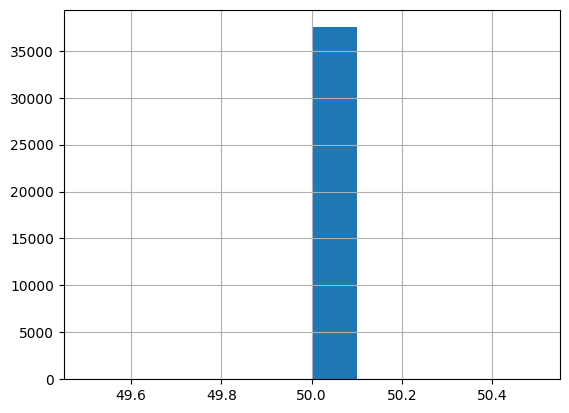

,0
count,37500.0
mean,50.0
std,0.0
min,50.0
25%,50.0
50%,50.0
75%,50.0
max,50.0


In [14]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [15]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [16]:
#we have very less number of reviews with length > 500.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

In [17]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [19]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,  80, 676,  16],
        [  0,   0,   0,  ...,  12, 239, 261],
        [  0,   0,   0,  ...,   0,   0,   0],
        ...,
        [  0,   0,   0,  ..., 429, 450, 278],
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0]])
Sample input: 
 tensor([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 1])


In [20]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)

        self.dropout = nn.Dropout(0.3)

        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        out = self.dropout(lstm_out)
        out = self.fc(out)

        sig_out = self.sig(out)

        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1]

        return sig_out, hidden



    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

In [24]:
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [21]:
no_layers = 2
vocab_size = len(vocab) + 1
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [26]:
import os
import torch
import torch.nn as nn
import numpy as np

clip = 5
epochs = 5
valid_loss_min = np.inf

epoch_tr_loss, epoch_vl_loss = [], []
epoch_tr_acc, epoch_vl_acc = [], []

save_path = './model_checkpoints'
os.makedirs(save_path, exist_ok=True)

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()

    h = model.init_hidden(batch_size)

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        h = tuple([each.data for each in h])

        model.zero_grad()
        output, h = model(inputs, h)

        loss = criterion(output.squeeze(), labels.float())
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_losses.append(loss.item())
        train_acc += acc(output, labels)

    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_h = tuple([each.data for each in val_h])

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            val_acc += acc(output, labels)

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc / len(train_loader.dataset)
    epoch_val_acc = val_acc / len(valid_loader.dataset)

    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    print(f'Epoch {epoch + 1}')
    print(f'Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}')
    print(f'Train Acc: {epoch_train_acc*100:.2f}% | Val Acc: {epoch_val_acc*100:.2f}%')

    if epoch_val_loss <= valid_loss_min:
        model_file = os.path.join(save_path, 'state_dict.pt')
        torch.save(model.state_dict(), model_file)
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {epoch_val_loss:.6f}). Model saved to {model_file}')
        valid_loss_min = epoch_val_loss

    print(25 * '==')


Epoch 1
Train Loss: 0.692156 | Val Loss: 0.692221
Train Acc: 52.21% | Val Acc: 51.86%
Validation loss decreased (inf --> 0.692221). Model saved to ./model_checkpoints/state_dict.pt
Epoch 2
Train Loss: 0.669326 | Val Loss: 0.557899
Train Acc: 57.01% | Val Acc: 72.68%
Validation loss decreased (0.692221 --> 0.557899). Model saved to ./model_checkpoints/state_dict.pt
Epoch 3
Train Loss: 0.448791 | Val Loss: 0.411067
Train Acc: 79.06% | Val Acc: 81.02%
Validation loss decreased (0.557899 --> 0.411067). Model saved to ./model_checkpoints/state_dict.pt
Epoch 4
Train Loss: 0.380369 | Val Loss: 0.393246
Train Acc: 82.96% | Val Acc: 82.41%
Validation loss decreased (0.411067 --> 0.393246). Model saved to ./model_checkpoints/state_dict.pt
Epoch 5
Train Loss: 0.358279 | Val Loss: 0.384698
Train Acc: 84.08% | Val Acc: 82.39%
Validation loss decreased (0.393246 --> 0.384698). Model saved to ./model_checkpoints/state_dict.pt


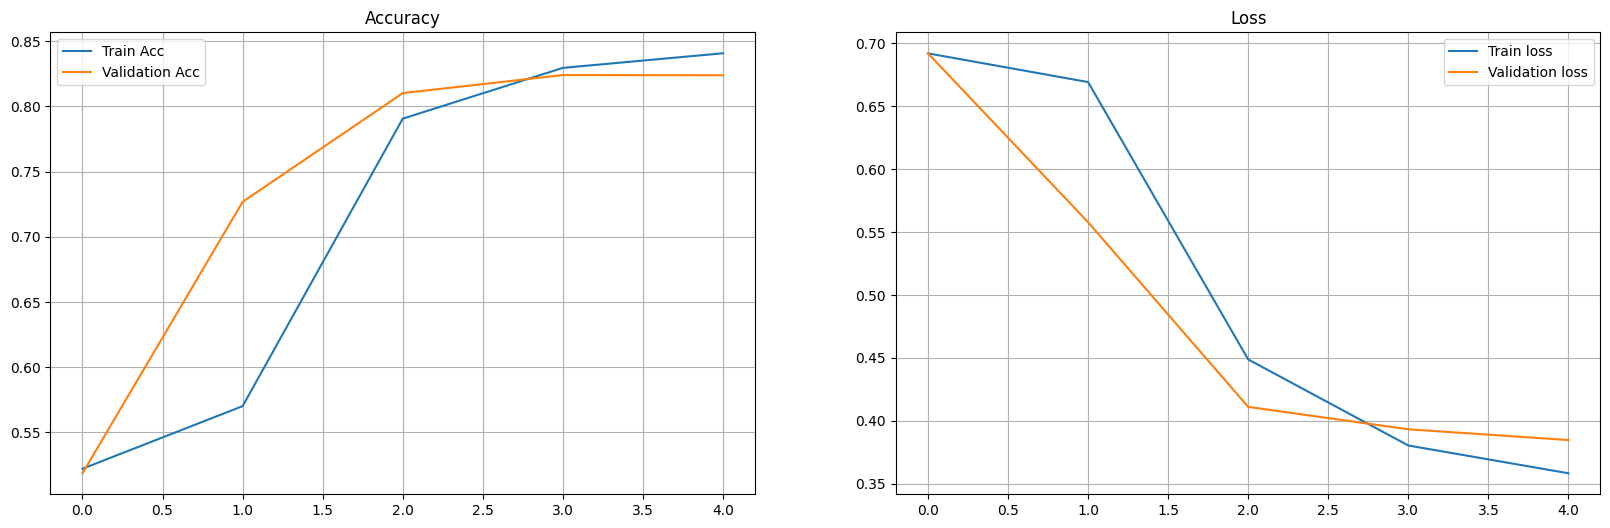

In [27]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [28]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [29]:
index = 30
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Taut and organically gripping, Edward Dmytryk's Crossfire is a distinctive suspense thriller, an unlikely "message" movie using the look and devices of the noir cycle.<br /><br />Bivouacked in Washington, DC, a company of soldiers cope with their restlessness by hanging out in bars. Three of them end up at a stranger's apartment where Robert Ryan, drunk and belligerent, beats their host (Sam Levene) to death because he happens to be Jewish. Police detective Robert Young investigates with the help of Robert Mitchum, who's assigned to Ryan's outfit. Suspicion falls on the second of the three (George Cooper), who has vanished. Ryan slays the third buddy (Steve Brodie) to insure his silence before Young closes in.<br /><br />Abetted by a superior script by John Paxton, Dmytryk draws precise performances from his three starring Bobs. Ryan, naturally, does his prototypical Angry White Male (and to the hilt), while Mitchum underplays with his characteristic alert nonchalance (his role, howeve

In [30]:
index = 32
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

My first exposure to the Templarios & not a good one. I was excited to find this title among the offerings from Anchor Bay Video, which has brought us other cult classics such as "Spider Baby". The print quality is excellent, but this alone can't hide the fact that the film is deadly dull. There's a thrilling opening sequence in which the villagers exact a terrible revenge on the Templars (& set the whole thing in motion), but everything else in the movie is slow, ponderous &, ultimately, unfulfilling. Adding insult to injury: the movie was dubbed, not subtitled, as promised on the video jacket.
Actual sentiment is  : negative
predicted sentiment is negative with a probability of 0.9461050294339657
